# Data pre-processing steps

This notebook will read the svs files in the data file using openslide python and apply the following pre-processing steps:

-Crop the images in small batches of size 896*896

-Filter out the tiles that contain less than 90% of brain (Tumor??) tissue: Hysteresis thresholding on the grayscale and 8-bit depth complemented image (http://ac.els-cdn.com/S1361841515001838/1-s2.0-S1361841515001838-main.pdf?_tid=f96cb1fa-35ba-11e7-b61d-00000aab0f6b&acdnat=1494446462_d2ee895640e38bd660bc559fc6233d34)

-Optional: Nuclei segmentation using morphometric top-hat filtering and hysteresis thresholding (http://ac.els-cdn.com/S1361841515001838/1-s2.0-S1361841515001838-main.pdf?_tid=f96cb1fa-35ba-11e7-b61d-00000aab0f6b&acdnat=1494446462_d2ee895640e38bd660bc559fc6233d34)

-Further tile to 224*224 (input size of a ResNet or Inception CNN)

input_size $= N*224*224*(1 \ or \ 3)$

label_size $= N$

N = Number_of_images * Number_of_patches

For now, the notebook only treats one svs file : "test.svs". The pre-processing steps are very computationnally expensive so we need to parallelize the code.

In [1]:
from openslide import *
import numpy as np
import skimage
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Main functions of openslide
#img.get_thumbnail((1000,1000))
#img.dimensions
#img.properties        
#img.level_count       
#img.level_dimensions  
#img.level_downsamples

# Batch Creation

In [2]:
#Split the image in patches, this process takes ~10min per image and need to be parallelized!! (GPU or multiple CPUs)

data_path = "/home/quin/data"
os.chdir(data_path)

img  = OpenSlide("test.svs")
height, width = img.dimensions
batch_size = 896
X_train = np.zeros((height*width/(batch_size**2), batch_size, batch_size, 3))

#pool = Pool()
#result1 = pool.apply_async(solve1, [A])    # evaluate "solve1(A)" asynchronously
#result2 = pool.apply_async(solve2, [B])    # evaluate "solve2(B)" asynchronously
#answer1 = result1.get(timeout=10)
#answer2 = result2.get(timeout=10)

def fill_X_train(i,j):
    batch = img.read_region(location = (i*batch_size,j*batch_size), level = 0, size = (batch_size,batch_size))
    X_train[i*(width/batch_size)+j,:,:,:] = np.array(batch.getdata())[:,0:-1].reshape((batch_size, batch_size, 3))

#args = [A, B]
#results = pool.map(solve1, args)

for i in xrange(height/batch_size):
    print ("iteration %d out of %d"%(i,height/batch_size))
    for j in xrange(width/batch_size):
        fill_X_train(i,j)
    #results = pool.map(fill_X_train, (i,xrange(width/batch_size)))

iteration 0 out of 29
iteration 1 out of 29
iteration 2 out of 29
iteration 3 out of 29
iteration 4 out of 29
iteration 5 out of 29
iteration 6 out of 29
iteration 7 out of 29
iteration 8 out of 29
iteration 9 out of 29
iteration 10 out of 29
iteration 11 out of 29
iteration 12 out of 29
iteration 13 out of 29
iteration 14 out of 29
iteration 15 out of 29
iteration 16 out of 29
iteration 17 out of 29
iteration 18 out of 29
iteration 19 out of 29
iteration 20 out of 29
iteration 21 out of 29
iteration 22 out of 29
iteration 23 out of 29
iteration 24 out of 29
iteration 25 out of 29
iteration 26 out of 29
iteration 27 out of 29
iteration 28 out of 29


# Batch Visualization

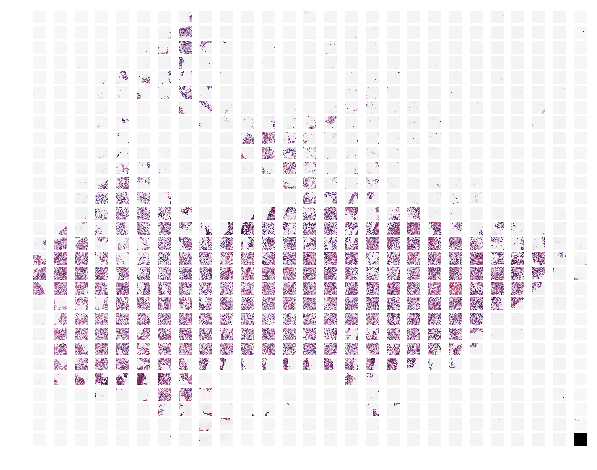

In [3]:

# Visualize batches from the WSI.

for i in xrange(height/batch_size):
    for j in xrange(width/batch_size):
        plt_idx = i*(width/batch_size) + j  + 1
        plt.subplot(height/batch_size, width/batch_size, plt_idx)
        plt.imshow(X_train[plt_idx].astype('uint8'))
        plt.axis('off')
plt.show()


# Filtering

iteration 0 out of 29
iteration 1 out of 29
iteration 2 out of 29
iteration 3 out of 29
iteration 4 out of 29
iteration 5 out of 29
iteration 6 out of 29
iteration 7 out of 29
iteration 8 out of 29
iteration 9 out of 29
iteration 10 out of 29
iteration 11 out of 29
iteration 12 out of 29
iteration 13 out of 29
iteration 14 out of 29
iteration 15 out of 29
iteration 16 out of 29
iteration 17 out of 29
iteration 18 out of 29
iteration 19 out of 29
iteration 20 out of 29
iteration 21 out of 29
iteration 22 out of 29
iteration 23 out of 29
iteration 24 out of 29
iteration 25 out of 29
iteration 26 out of 29
iteration 27 out of 29
iteration 28 out of 29


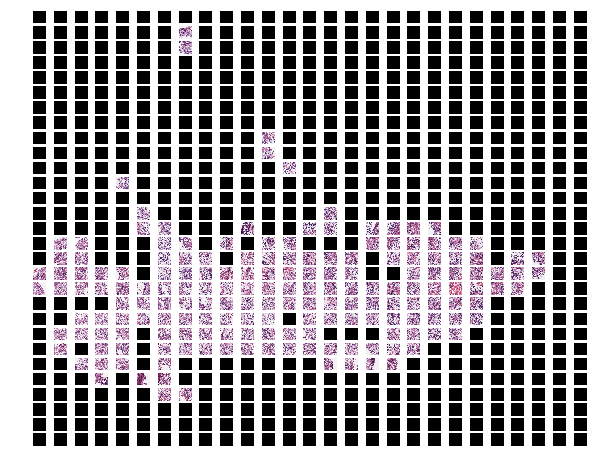

In [137]:
from PIL import Image
from skimage import feature

import scipy.ndimage as ndi
from scipy.ndimage import (gaussian_filter,
                           generate_binary_structure, binary_erosion, label)

import matplotlib.image as mpimg


# modified from Canny edge detection algo
# https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/_canny.py#L53
def canny_hyst(image, low_threshold, high_threshold):
    #
    # The steps involved:
    #
    # * Label all points above the high threshold as edges.
    # * Recursively label any point above the low threshold that is 8-connected
    #   to a labeled point as an edge.
    #
    # Regarding masks, any point touching a masked point will have a gradient
    # that is "infected" by the masked point, so it's enough to erode the
    # mask by one and then mask the output. We also mask out the border points
    # because who knows what lies beyond the edge of the image?
    #

    #
    #---- Create two masks at the two thresholds.
    #
    high_mask = (image >= high_threshold)
    low_mask = (image >= low_threshold)
    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                             np.arange(count, dtype=np.int32) + 1),
                     copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask

def greyscale(img):
    # http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
    # Method #1: PIL conversion
    #pil_greyscale = Image.fromarray(img, 'RGB').convert(mode = 'L')
    #pil_greyscale = np.array(pil_greyscale.getdata()).reshape((H, W,))
    #print ("PIL conversion")
    #plt.imshow(pil_greyscale.astype('uint8'), cmap='gray')
    #plt.show()

    # Method #2: LUMA coding
    luma_greyscale = np.dot(img[...,:3], [0.299, 0.587, 0.114])
    return luma_greyscale

def autocontrast(grey_img):
    H, W = grey_img.shape
    # Translated Divakar's Matlab code
    # https://www.mathworks.com/matlabcentral/fileexchange/10566-auto-contrast
    low_limit=0.008
    up_limit=0.992
    grey_img_flat = np.sort(grey_img.reshape(H * W))
    #print (grey_img_flat[int(np.ceil(low_limit*H*W))], grey_img_flat[int(np.ceil(up_limit*H*W))])
    v_min = grey_img_flat[int(np.ceil(low_limit*H*W))]
    v_max = grey_img_flat[int(np.ceil(up_limit*H*W))]
    grey_img = (grey_img-v_min)/(v_max-v_min)
    grey_img *= 255
    return grey_img

def complement(grey_img):
    # Performing 8-bit complement
    # http://micro.magnet.fsu.edu/primer/java/digitalimaging/processing/complementimage/
    return 255 - grey_img
    
def filter (img, debug = False):
    if debug:
        print ("Original Image")
        plt.imshow(img.astype('uint8'))
        plt.show()
    
    H, W, C = img.shape

    # Grayscale
    img = greyscale(img)
    if debug:
        print ("LUMA coding")
        plt.imshow(img.astype('uint8'), cmap='gray')
        plt.show()

    # TODO: This doesnt give us the results we are looking for
    # Autocontrast
    #img = autocontrast(img)
    #if debug:
    #    print ("Auto Contrast")
    #    plt.imshow(img.astype('uint8'), cmap='gray')
    #    plt.show()

    # Performing 8-bit complement
    # http://micro.magnet.fsu.edu/primer/java/digitalimaging/processing/complementimage/
    img = complement(img)
    if debug:
        print ("8-bit Complement")
        plt.imshow(img.astype('uint8'), cmap='gray')
        plt.show()

    # Hysteresis Thresholding
    img = canny_hyst(img, 50, 100)
    if debug:
        print ("Hysteresis 2")
        plt.imshow(img.astype('uint8'), cmap='gray')
        plt.show()

    if debug:
        print (float(np.sum(img)))
        print float(np.sum(img)) / (H*W)
    return float(np.sum(img)) / (H*W)

tissues = set()
for i in xrange(height/batch_size):
    print ("iteration %d out of %d"%(i,height/batch_size))
    for j in xrange(width/batch_size):
        img = X_train[i*(width/batch_size) + j  + 1]
        if filter(img) >= 0.5:
            tissues.add(i*(width/batch_size) + j  + 1)

black_tile = np.zeros((batch_size, batch_size))
for i in xrange(height/batch_size):
    for j in xrange(width/batch_size):
        plt_idx = i*(width/batch_size) + j  + 1
        plt.subplot(height/batch_size, width/batch_size, plt_idx)
        if plt_idx in tissues:
            plt.imshow(X_train[plt_idx].astype('uint8')) 
        else:
            plt.imshow(black_tile.astype('uint8'))
        plt.axis('off')
plt.show()


In [4]:
#Experimenting with the multiprocessing package to parallelize on the 8 CPUs
import time
from multiprocessing import Pool

def f(x):
    return x**3

A1 = np.zeros(100)
A2 = np.zeros(100)
start1 = time.time()
for i in xrange(100):   
    A1[i] = f(i)
end1 = time.time()
elapsed1 = end1 - start1

start2 = time.time()
pool = Pool()
results = pool.map(f, xrange(100))
end2 = time.time()
elapsed2 = end2 - start2
  
print("time with unparallelized implementation %f"%elapsed1)    
print("time with parallelized implementation %f"%elapsed2)    

#Using the "map" function, it is weird because the operation time increases!!


time with unparallelized implementation 0.000140
time with parallelized implementation 0.019719


In [45]:
from multiprocessing import Process, Queue
import time

def f(x):
    A[x] = x**3

if __name__ == '__main__':

    #q = Queue()
    #The list of examples that we want to compute
    examples = [i for i in xrange(1000)]

    # normal approach
    A = np.zeros(1000)
    t = time.time()
    for example in examples:
        f(example)
    elapsed1 = time.time()-t

    #Parallel approach
    A = np.zeros(1000)
    t = time.time()
    #Split work into 8 processes (8 cores)
    processes = 8
    #Split the input in 8 chunks for each processes
    chunksize = len(examples)/processes
    examplessplitted = [examples[x:x+chunksize] for x in xrange(0, len(examples), chunksize)]
    for subexample in examplessplitted:
        p = Process(target=f, args=(subexample))
        p.Daemon = True
        p.start()
    for subexample in examplessplitted:
        p.join()
    elapsed2 = time.time()-t
    #print A
        

0.000295162200928
8


Process Process-281:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-282:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
TypeError: f() takes exactly 1 argument (125 given)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
TypeError: f() takes exactly 1 argument (125 given)
Process Process-283:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
TypeError: f() takes exactly 1 argument (125 given)
Process Process-284:
Traceback (mo

0.190186977386


TypeError: f() takes exactly 1 argument (125 given)
Process Process-287:
Process Process-288:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
TypeError: f() takes exactly 1 argument (125 given)
TypeError: f() takes exactly 1 argument (125 given)
